`NstepRNN`系はcudnnを使っているため中断すると確実にカーネルが落ちる

In [1]:
%matplotlib inline
import sys
sys.path.append("../")
import pickle
import numpy as np
from tqdm import tqdm_notebook
from utils import *
from prefetch_generator import BackgroundGenerator
from multiprocessing_generator import ParallelGenerator
from matplotlib import pylab as plt
from IPython.display import clear_output
from chainer import training, iterators
from chainer import serializers
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import nltk
from glob import glob
from joblib import Parallel, delayed
from collections import Counter
os.environ["CHAINER_TYPE_CHECK"] = "0"

In [2]:
trn_data = read_pickle("../dataset/nl/train.pkl")
vld_data = read_pickle("../dataset/nl/valid.pkl")
tst_data = read_pickle("../dataset/nl/test.pkl")
code_i2w = read_pickle("../dataset/code_i2w.pkl")
code_w2i = read_pickle("../dataset/code_w2i.pkl")
nl_i2w = read_pickle("../dataset/nl_i2w.pkl")
nl_w2i = read_pickle("../dataset/nl_w2i.pkl")

In [3]:
trn_x, trn_y_raw = zip(*trn_data.items())
vld_x, vld_y_raw = zip(*vld_data.items())
tst_x, tst_y_raw = zip(*tst_data.items())

In [4]:
trn_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in trn_y_raw]
vld_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in vld_y_raw]
tst_y = [[nl_w2i[t] if t in nl_w2i.keys() else nl_w2i["<UNK>"] for t in l] for l in tst_y_raw]

In [5]:
# model defining
from layers import *
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import Chain
from chainer import optimizers
from chainer import Variable
from chainer import cuda
from chainer.cuda import to_gpu, to_cpu
from chainer import initializers
from chainer.dataset import to_device
import cupy as xp
from layers import TreeEmbeddingLayer, ShidoTreeLSTM

class ChildSumLSTMLayer(Chain):
    def __init__(self, dim_in, dim_out, dropout=0.0):
        super(ChildSumLSTMLayer, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dropout = dropout
        with self.init_scope():
            self.U_f = L.Linear(dim_out, dim_out, nobias=True)
            self.U_iuo = L.Linear(dim_out, dim_out * 3, nobias=True)
            self.W = L.Linear(dim_in, dim_out * 4)
            self.h_init = chainer.Parameter(chainer.initializers.HeNormal(), (1, dim_out))

    def get_child_c_tensor(self, node):
        '''return: [children, dim_out]'''
        if node.children == []:
            return self.xp.zeros((1, self.dim_out), "float32")
        else:
            return F.stack([child.c for child in node.children])

    def get_child_h_tensor(self, node):
        '''return: [children, dim_out]'''
        if node.children == []:
            return self.h_init
        else:
            return F.stack([child.h for child in node.children])

    def __call__(self, roots):
        depthes = [x[1] for x in sorted(depth_split_batch(
            roots).items(), key=lambda x:-x[0])]  # list of list of Nodes
        for nodes in depthes:
            self.apply(nodes)
        return depthes[-1]

    def apply(self, nodes):
        child_hs = [self.get_child_h_tensor(node) for node in nodes]  # (node, [child, dim_out])
        child_cs = [self.get_child_c_tensor(node) for node in nodes]  # (node, [child, dim_out])

        h_sum = F.stack([F.sum(h, 0) for h in child_hs])  # [nodes, dim_out]
        x = F.stack([node.h for node in nodes])  # [nodes, dim_in]
        W_x = self.W(x)  # [nodes, dim_out * 4]
        W_f_x = W_x[:, :self.dim_out * 1]  # [nodes, dim_out]
        W_i_x = W_x[:, self.dim_out * 1:self.dim_out * 2]
        W_u_x = W_x[:, self.dim_out * 2:self.dim_out * 3]
        W_o_x = W_x[:, self.dim_out * 3:]

        branch_f_k = sequence_apply(self.U_f, child_hs)  # (node, [child, dim_out])
        branch_f_k = [F.sigmoid(F.broadcast_to(W_f_x[e:e + 1], h.shape) + h)
                      for e, h in enumerate(branch_f_k)]
        branch_f = F.stack([F.sum(f_k * c, 0)
                            for f_k, c in zip(branch_f_k, child_cs)])  # [node, dim_out]

        branch_iuo = self.U_iuo(h_sum)  # [nodes, dim_out * 3]
        branch_i = F.sigmoid(branch_iuo[:, :self.dim_out * 1] + W_i_x)   # [nodes, dim_out]
        branch_u = F.tanh(branch_iuo[:, self.dim_out * 1:self.dim_out * 2] + W_u_x)
        branch_o = F.sigmoid(branch_iuo[:, self.dim_out * 2:] + W_o_x)

        new_c = branch_i * branch_u + branch_f  # [node, dim_out]
        new_h = branch_o * F.tanh(new_c)  # [node, dim_out]

        for n, c, h in zip(nodes, new_c, new_h):
            n.c = c
            n.h = h
            
class Model(Chain):

    def __init__(self, dim_E, dim_F, dim_rep, in_vocab, out_vocab):
        n_layers = 1
        super(Model, self).__init__(
            E = TreeEmbeddingLayer(dim_E, len(code_i2w)),
            F = L.EmbedID(len(nl_i2w), dim_F, initializers.HeNormal(), -1),
            encoder = ChildSumLSTMLayer(dim_E, dim_rep),
            decoder = LSTM_Attention_Decoder(n_layers, dim_F, dim_rep, 0.0),
            W = L.Linear(dim_rep, len(nl_i2w))
        )

    def encode(self, trees):
        """
        labels, relations, coefs: array
        texts: list of list
        """
        # Encode
        trees = [self.E(tree) for tree in trees]
        trees = self.encoder(trees)
        
        hx = F.expand_dims(F.stack([tree.h for tree in trees]), 0)
        cx = F.expand_dims(F.stack([tree.c for tree in trees]), 0)
        ys = [F.stack([node.h for node in traverse(tree)]) for tree in trees]
        
        return(hx, cx, ys)
    
    def get_loss(self, seq, texts):

        hx, cx, ys = self.encode(seq)
        
        # Decode       
        ys_in = [text[:-1] for text in texts]
        ys_out = [text[1:] for text in texts]
        
        texts_embed = sequence_embed(self.F, ys_in)
        batch = len(texts)
        
        _, _, os = self.decoder(hx, cx, ys, texts_embed) # cx: (n_layers, batch, dim) <- WTF
        
        # Loss
        concat_os = F.concat(os, axis=0)
        concat_ys_out = F.concat(ys_out, axis=0)
        loss = F.sum(F.softmax_cross_entropy(self.W(concat_os), concat_ys_out, reduce='no')) / batch
        
        return(loss)
    
    def translate(self, seq, max_length=100):
        with chainer.no_backprop_mode(), chainer.using_config('train', False):
            batch = len(seq)
            hx, cx, y_enc = self.encode(seq)
            ys = self.xp.full(batch, 0, 'i')
            h, c = hx, cx
            result = []
            for i in range(max_length):
                eys = self.F(ys)
                eys = F.split_axis(eys, batch, 0)
                h, c, ys = self.decoder(h, c, y_enc, eys)
                cys = F.concat(ys, axis=0)
                wy = self.W(cys)
                ys = self.xp.argmax(wy.data, axis=1).astype('i')
                result.append(ys)
            result = cuda.to_cpu(self.xp.concatenate([self.xp.expand_dims(x, 0) for x in result]).T)
            # Remove EOS taggs
            outs = []
            for y in result:
                inds = numpy.argwhere(y == 0)
                if len(inds) > 0:
                    y = y[:inds[0, 0]]
                outs.append(y)
            return(outs)
    
    def beamseach(self, seq, width=3, max_length=100):
        with chainer.no_backprop_mode(), chainer.using_config('train', False):
            h, c, y_enc = self.encode([seq])
            ys = self.xp.full(1, 0, 'i')
            hyps = [(h, c, ys, 0.0, [])]
            for i in range(max_length):
                new_hyps = []
                for h, c, ys, prob, result in hyps:
                    eys = self.F(ys)
                    eys = F.split_axis(eys.data, eys.shape[0], 0)
                    h, c, ys = self.decoder(h, c, y_enc, eys)
                    cys = F.concat(ys, 0).data
                    output_prob = F.softmax(self.W(cys)).data
                    log_prob = self.xp.log(output_prob)[0]
                    log_prob[self.xp.isnan(log_prob)] = - self.xp.float32("inf")
                    ys_order = self.xp.argsort(log_prob).astype('i')[::-1]
                    for y in ys_order[:5]:
                        if len(result) > 0 and result[-1] == 0:
                            new_hyps.append((h.data, c.data, self.xp.expand_dims(y, -1), prob, result))
                        else:
                            new_hyps.append(
                                (h.data, c.data,self.xp.expand_dims(y, -1),
                                (prob + log_prob[y]) / 6 * (5 + len(result)), result + [y.tolist()]))
                new_hyps = sorted(new_hyps, key=lambda x: x[3], reverse=True)[:5]
                hyps = new_hyps
            y = numpy.array(hyps[0][4])
            inds = numpy.argwhere(y == 0)
            if len(inds) > 0:
                y = y[:inds[0, 0]]
            return y
    
    def beamseach_batch(self, seq, width=3, max_length=100):
        return [self.beamseach(s, width, max_length) for s in seq]

In [6]:
# setting model
model = Model(512, 512, 512, len(code_w2i), len(nl_w2i))
model.to_gpu(0)
epochs = 20
batch_size = 10
optimizer = optimizers.Adam()
optimizer.setup(model)
history = {"loss":[], "loss_val":[], "bleu": []}

In [7]:
# Setting Data Generator
def mygen(X, Y, batch_size, code_dic, nl_dic, train=True):
    epoch = 0
    while 1:
        if train:
            np.random.seed(epoch)
            newindex = list(np.random.permutation(len(X)))
            X = [X[i] for i in newindex]
            Y = [Y[i] for i in newindex]
        for i in range(0, len(X), batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            x = [consult_tree(read_pickle(n), code_dic) for n in x]
            y = [np.array(yy, "int32") for yy in y]
            yield(x, y)
        epoch += 1

trn_gen = BackgroundGenerator(mygen(trn_x, trn_y, batch_size, code_w2i, nl_w2i, train=True), max_prefetch=2)
vld_gen = BackgroundGenerator(mygen(vld_x, vld_y, batch_size, code_w2i, nl_w2i, train=False), max_prefetch=2)
tst_gen = BackgroundGenerator(mygen(tst_x, tst_y, batch_size, code_w2i, nl_w2i, train=False), max_prefetch=2)

In [8]:
# training
for epoch in range(epochs):
    
    # train
    tmp_loss = 0.0
    for _ in tqdm_notebook(range(0, len(trn_x), batch_size), desc="train"):
        x, y = next(trn_gen)
        y = to_device0(y)
        
        loss = model.get_loss(x, y)
        print("cleargrads")
        model.cleargrads()
        print("backward")
        loss.backward()
        print("update")
        optimizer.update()
        print("end")
        tmp_loss += float(loss.data) * len(y)
        
    history["loss"].append(tmp_loss / len(Y_trn))
    
    # loss evaluation
    with chainer.no_backprop_mode(), chainer.using_config('train', False):
        tmp_loss = 0.0
        for i in tqdm_notebook(range(0, len(X_tst), batch_size), desc="eval"):
            x, y = next(tst_gen)
            x = to_device0(x)
            y = to_device0(y)

            loss = model.get_loss(x, y).data
            tmp_loss += float(loss) * len(y)

    # bleu evaluation
        refs, hyps = [], []
        for i in tqdm_notebook(range(0, len(X_tst), batch_size), desc="bleu"):
            x, y = next(bleu_gen)
            x = to_device0(x)
            result = to_cpu(model.translate(x))
            refs += [[item.tolist()] for item in y]
            hyps += [item.tolist() for item in result]
        bleu = nltk.translate.bleu_score.corpus_bleu(
            refs,
            hyps,
            smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
        
    history["loss_val"].append(tmp_loss / len(Y_tst))
    history["bleu"].append(bleu)
    
    # checkpoint
    if bleu == max(history["bleu"]):
        model.to_cpu()
        serializers.save_npz("models/seq2seq_attention_drop.npz", model)
        model.to_gpu()
    
    # print
    clear_output()
    for key, val in history.items():
        if "loss" in key:
            plt.plot(val, label=key)
    plt.legend()
    plt.show()
    for key, val in history.items():
        if "bleu" in key:
            plt.plot(val, label=key)
    plt.legend()
    plt.show()
    
    optimizer.new_epoch()

A Jupyter Widget

em


  4%|▍         | 1/26 [00:00<00:03,  7.24it/s]

enc


100%|██████████| 26/26 [00:01<00:00, 15.07it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/14 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 31.37it/s]


gomi
dec
loss
cleargrads
backward
update
end
em


 41%|████      | 7/17 [00:00<00:00, 50.97it/s]

enc


100%|██████████| 17/17 [00:00<00:00, 23.62it/s]


gomi
dec
loss
cleargrads
backward


 33%|███▎      | 8/24 [00:00<00:00, 72.79it/s]

update
end
em
enc


100%|██████████| 24/24 [00:00<00:00, 33.41it/s]


gomi
dec
loss
cleargrads
backward


 45%|████▌     | 10/22 [00:00<00:00, 98.69it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 29.46it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 11/22 [00:00<00:00, 92.98it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 33.01it/s]


gomi
dec
loss
cleargrads
backward


 46%|████▌     | 11/24 [00:00<00:00, 97.60it/s]

update
end
em
enc


100%|██████████| 24/24 [00:00<00:00, 38.14it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/17 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 33.12it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/35 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 35/35 [00:02<00:00, 17.37it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 8/17 [00:00<00:00, 68.84it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 18.78it/s]


gomi
dec
loss
cleargrads
backward


 67%|██████▋   | 10/15 [00:00<00:00, 75.99it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 53.57it/s]


gomi
dec
loss
cleargrads
backward


 24%|██▍       | 9/37 [00:00<00:00, 81.34it/s]

update
end
em
enc


100%|██████████| 37/37 [00:00<00:00, 46.25it/s]


gomi
dec
loss
cleargrads
backward


 29%|██▉       | 5/17 [00:00<00:00, 48.76it/s]

update
end
em
enc


100%|██████████| 17/17 [00:01<00:00, 12.80it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/22 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 22/22 [00:01<00:00, 18.72it/s]


gomi
dec
loss
cleargrads
backward


 52%|█████▏    | 13/25 [00:00<00:00, 123.35it/s]

update
end
em
enc


100%|██████████| 25/25 [00:00<00:00, 64.56it/s] 


gomi
dec
loss
cleargrads
backward


 37%|███▋      | 7/19 [00:00<00:00, 59.95it/s]

update
end
em
enc


100%|██████████| 19/19 [00:00<00:00, 27.88it/s]


gomi
dec
loss
cleargrads
backward


 42%|████▏     | 11/26 [00:00<00:00, 105.36it/s]

update
end
em
enc


100%|██████████| 26/26 [00:00<00:00, 29.17it/s] 


gomi
dec
loss
cleargrads
backward


 45%|████▌     | 9/20 [00:00<00:00, 82.48it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 31.11it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 8/15 [00:00<00:00, 64.57it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 46.05it/s]


gomi
dec
loss
cleargrads
backward


 59%|█████▉    | 16/27 [00:00<00:00, 159.49it/s]

update
end
em
enc


100%|██████████| 27/27 [00:00<00:00, 66.33it/s] 


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 21/45 [00:00<00:00, 204.12it/s]

update
end
em
enc


100%|██████████| 45/45 [00:00<00:00, 65.25it/s] 


gomi
dec
loss
cleargrads
backward


  0%|          | 0/15 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 28.88it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 12/30 [00:00<00:00, 103.17it/s]

update
end
em
enc


100%|██████████| 30/30 [00:01<00:00, 22.88it/s] 


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 9/21 [00:00<00:00, 86.04it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 32.74it/s]


gomi
dec
loss
cleargrads
backward


 37%|███▋      | 7/19 [00:00<00:00, 66.83it/s]

update
end
em
enc


100%|██████████| 19/19 [00:01<00:00, 16.64it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/20 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


gomi
dec
loss
cleargrads
backward


 59%|█████▉    | 23/39 [00:00<00:00, 216.78it/s]

update
end
em
enc


100%|██████████| 39/39 [00:01<00:00, 35.27it/s] 


gomi
dec
loss
cleargrads
backward


 44%|████▍     | 8/18 [00:00<00:00, 71.38it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 28.01it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/17 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 17/17 [00:01<00:00, 14.14it/s]


gomi
dec
loss
cleargrads
backward


 52%|█████▏    | 11/21 [00:00<00:00, 100.06it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 53.57it/s] 


gomi
dec
loss
cleargrads
backward


  0%|          | 0/25 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 25/25 [00:00<00:00, 26.33it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/21 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 21/21 [00:02<00:00,  8.94it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 7/15 [00:00<00:00, 55.35it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 42.67it/s]


gomi
dec
loss
cleargrads
backward


 39%|███▉      | 7/18 [00:00<00:00, 60.74it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 29.87it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/23 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 23/23 [00:02<00:00,  9.66it/s]


gomi
dec
loss
cleargrads
backward


 46%|████▌     | 11/24 [00:00<00:00, 88.69it/s]

update
end
em
enc


100%|██████████| 24/24 [00:00<00:00, 35.60it/s]


gomi
dec
loss
cleargrads
backward


 26%|██▌       | 6/23 [00:00<00:00, 51.00it/s]

update
end
em
enc


100%|██████████| 23/23 [00:01<00:00, 16.72it/s]


gomi
dec
loss
cleargrads
backward


 41%|████      | 9/22 [00:00<00:00, 79.12it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 38.38it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/15 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 9/17 [00:00<00:00, 79.60it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 42.99it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 9/17 [00:00<00:00, 70.10it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 46.18it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 8/21 [00:00<00:00, 74.49it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


gomi
dec
loss
cleargrads
backward


 67%|██████▋   | 8/12 [00:00<00:00, 65.68it/s]

update
end
em
enc


100%|██████████| 12/12 [00:00<00:00, 49.59it/s]


gomi
dec
loss
cleargrads
backward


 44%|████▍     | 8/18 [00:00<00:00, 61.93it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 30.78it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 9/18 [00:00<00:00, 86.23it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 57.66it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 7/15 [00:00<00:00, 55.51it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


gomi
dec
loss
cleargrads
backward


 52%|█████▏    | 12/23 [00:00<00:00, 106.00it/s]

update
end
em
enc


100%|██████████| 23/23 [00:00<00:00, 38.21it/s] 


gomi
dec
loss
cleargrads
backward


 56%|█████▌    | 10/18 [00:00<00:00, 83.31it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 48.11it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 9/18 [00:00<00:00, 85.51it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 22.52it/s]


gomi
dec
loss
cleargrads
backward


 35%|███▌      | 7/20 [00:00<00:00, 69.20it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 21.50it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 9/17 [00:00<00:00, 78.35it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 41.11it/s]


gomi
dec
loss
cleargrads
backward
update
end
em


 16%|█▌        | 3/19 [00:00<00:00, 24.33it/s]

enc


100%|██████████| 19/19 [00:00<00:00, 27.74it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 11/22 [00:00<00:00, 93.76it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 34.66it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/22 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 22/22 [00:01<00:00, 21.14it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/25 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 25/25 [00:01<00:00, 16.26it/s]


gomi
dec
loss
cleargrads
backward


 33%|███▎      | 6/18 [00:00<00:00, 53.08it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 20.91it/s]


gomi
dec
loss
cleargrads
backward


 44%|████▍     | 11/25 [00:00<00:00, 107.26it/s]

update
end
em
enc


100%|██████████| 25/25 [00:01<00:00, 22.21it/s] 


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 8/15 [00:00<00:00, 68.77it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 45.90it/s]


gomi
dec
loss
cleargrads
backward


 39%|███▉      | 9/23 [00:00<00:00, 72.57it/s]

update
end
em
enc


100%|██████████| 23/23 [00:00<00:00, 29.03it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/13 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 13/13 [00:00<00:00, 17.96it/s]


gomi
dec
loss
cleargrads
backward
update
end
em


 23%|██▎       | 7/30 [00:00<00:00, 55.19it/s]

enc


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/23 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 23/23 [00:00<00:00, 31.95it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 6/16 [00:00<00:00, 59.91it/s]

update
end
em
enc


100%|██████████| 16/16 [00:00<00:00, 18.07it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/20 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


gomi
dec
loss
cleargrads
backward


 33%|███▎      | 7/21 [00:00<00:00, 53.97it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 43.77it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/26 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 26/26 [00:00<00:00, 34.23it/s]


gomi
dec
loss
cleargrads
backward
update
end
em


 40%|████      | 6/15 [00:00<00:00, 49.16it/s]

enc


100%|██████████| 15/15 [00:00<00:00, 37.57it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/18 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 18/18 [00:01<00:00, 16.08it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/15 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 6/14 [00:00<00:00, 40.20it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 29.37it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 6/12 [00:00<00:00, 49.25it/s]

update
end
em
enc


100%|██████████| 12/12 [00:00<00:00, 37.41it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 9/19 [00:00<00:00, 87.21it/s]

update
end
em
enc


100%|██████████| 19/19 [00:01<00:00, 18.60it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/16 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 16/16 [00:00<00:00, 23.43it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 8/20 [00:00<00:00, 74.98it/s]

update
end
em
enc


100%|██████████| 20/20 [00:01<00:00, 19.02it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/16 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 16/16 [00:00<00:00, 30.97it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/23 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 23/23 [00:01<00:00, 20.91it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 8/17 [00:00<00:00, 59.67it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 35.07it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 6/14 [00:00<00:00, 45.45it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 33.93it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/20 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 20/20 [00:01<00:00, 17.36it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 9/21 [00:00<00:00, 89.50it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 45.37it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 8/20 [00:00<00:00, 63.28it/s]

update
end
em
enc


100%|██████████| 20/20 [00:01<00:00, 16.77it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/22 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 32.83it/s]


gomi
dec
loss
cleargrads
backward


 27%|██▋       | 7/26 [00:00<00:00, 67.16it/s]

update
end
em
enc


100%|██████████| 26/26 [00:01<00:00, 17.71it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/16 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 16/16 [00:00<00:00, 29.76it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 9/24 [00:00<00:00, 86.00it/s]

update
end
em
enc


100%|██████████| 24/24 [00:00<00:00, 46.12it/s]


gomi
dec
loss
cleargrads
backward


 48%|████▊     | 10/21 [00:00<00:00, 79.07it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 6/15 [00:00<00:00, 57.96it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 38.24it/s]


gomi
dec
loss
cleargrads
backward


 44%|████▍     | 8/18 [00:00<00:00, 57.67it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 36.57it/s]


gomi
dec
loss
cleargrads
backward


 44%|████▍     | 11/25 [00:00<00:00, 98.85it/s]

update
end
em
enc


100%|██████████| 25/25 [00:01<00:00, 20.75it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 8/20 [00:00<00:00, 72.38it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 23.40it/s]


gomi
dec
loss
cleargrads
backward


 27%|██▋       | 6/22 [00:00<00:00, 56.15it/s]

update
end
em
enc


100%|██████████| 22/22 [00:01<00:00, 15.75it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/33 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 33/33 [00:02<00:00, 13.06it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/23 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 23/23 [00:01<00:00, 16.08it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 6/14 [00:00<00:00, 57.63it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 39.76it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 6/14 [00:00<00:00, 42.78it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 37.54it/s]


gomi
dec
loss
cleargrads
backward


 37%|███▋      | 7/19 [00:00<00:00, 54.58it/s]

update
end
em
enc


100%|██████████| 19/19 [00:01<00:00, 16.34it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 11/22 [00:00<00:00, 105.44it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 34.26it/s] 


gomi
dec
loss
cleargrads
backward


  0%|          | 0/18 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 18/18 [00:01<00:00, 17.10it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/28 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 28/28 [00:01<00:00, 19.58it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 7/15 [00:00<00:00, 69.15it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 39.94it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/19 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 19/19 [00:01<00:00, 18.56it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 10/19 [00:00<00:00, 90.47it/s]

update
end
em
enc


100%|██████████| 19/19 [00:00<00:00, 34.61it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 10/20 [00:00<00:00, 88.53it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 40.59it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 10/19 [00:00<00:00, 98.70it/s]

update
end
em
enc


100%|██████████| 19/19 [00:00<00:00, 41.52it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 10/26 [00:00<00:00, 90.43it/s]

update
end
em
enc


100%|██████████| 26/26 [00:00<00:00, 29.85it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/22 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 22/22 [00:01<00:00, 14.98it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/20 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 20/20 [00:01<00:00, 11.06it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/19 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 19/19 [00:01<00:00, 18.06it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/27 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 27/27 [00:01<00:00, 22.81it/s]


gomi
dec
loss
cleargrads
backward


 55%|█████▌    | 11/20 [00:00<00:00, 90.87it/s]

update
end
em
enc


100%|██████████| 20/20 [00:00<00:00, 51.23it/s]


gomi
dec
loss
cleargrads
backward


 41%|████      | 7/17 [00:00<00:00, 60.11it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 27.68it/s]


gomi
dec
loss
cleargrads
backward


 41%|████      | 9/22 [00:00<00:00, 79.77it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 41.00it/s]


gomi
dec
loss
cleargrads
backward


 42%|████▏     | 8/19 [00:00<00:00, 73.25it/s]

update
end
em
enc


100%|██████████| 19/19 [00:00<00:00, 31.07it/s]


gomi
dec
loss
cleargrads
backward


 46%|████▌     | 12/26 [00:00<00:00, 107.71it/s]

update
end
em
enc


100%|██████████| 26/26 [00:01<00:00, 20.67it/s] 


gomi
dec
loss
cleargrads
backward


  0%|          | 0/17 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 19.94it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/16 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 8/17 [00:00<00:00, 57.79it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 30.37it/s]


gomi
dec
loss
cleargrads
backward


 57%|█████▋    | 12/21 [00:00<00:00, 99.59it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 51.24it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 6/12 [00:00<00:00, 52.84it/s]

update
end
em
enc


100%|██████████| 12/12 [00:00<00:00, 15.63it/s]


gomi
dec
loss
cleargrads
backward


 40%|████      | 12/30 [00:00<00:00, 118.39it/s]

update
end
em
enc


100%|██████████| 30/30 [00:00<00:00, 36.00it/s] 


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 10/26 [00:00<00:00, 87.23it/s]

update
end
em
enc


100%|██████████| 26/26 [00:01<00:00, 20.13it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 9/18 [00:00<00:00, 70.71it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 21.71it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 22/47 [00:00<00:00, 214.91it/s]

update
end
em
enc


100%|██████████| 47/47 [00:01<00:00, 29.36it/s] 


gomi
dec
loss
cleargrads
backward


 35%|███▍      | 9/26 [00:00<00:00, 89.32it/s]

update
end
em
enc


100%|██████████| 26/26 [00:01<00:00, 20.81it/s]


gomi
dec
loss
cleargrads
backward


 59%|█████▉    | 10/17 [00:00<00:00, 81.97it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 55.15it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 8/21 [00:00<00:00, 58.58it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 30.77it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/25 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 25/25 [00:01<00:00, 14.03it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/31 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 31/31 [00:01<00:00, 18.99it/s]


gomi
dec
loss
cleargrads
backward


 47%|████▋     | 7/15 [00:00<00:00, 51.57it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 36.14it/s]


gomi
dec
loss
cleargrads
backward


 57%|█████▋    | 12/21 [00:00<00:00, 90.42it/s]

update
end
em
enc


100%|██████████| 21/21 [00:01<00:00, 20.60it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/22 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 22/22 [00:01<00:00, 17.20it/s]


gomi
dec
loss
cleargrads
backward


 39%|███▉      | 9/23 [00:00<00:00, 76.54it/s]

update
end
em
enc


100%|██████████| 23/23 [00:00<00:00, 32.71it/s]


gomi
dec
loss
cleargrads
backward


 53%|█████▎    | 8/15 [00:00<00:00, 67.18it/s]

update
end
em
enc


100%|██████████| 15/15 [00:00<00:00, 45.83it/s]


gomi
dec
loss
cleargrads
backward


 50%|█████     | 11/22 [00:00<00:00, 85.15it/s]

update
end
em
enc


100%|██████████| 22/22 [00:00<00:00, 23.64it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 9/21 [00:00<00:00, 75.95it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 40.09it/s]


gomi
dec
loss
cleargrads
backward


 39%|███▉      | 9/23 [00:00<00:00, 79.34it/s]

update
end
em
enc


100%|██████████| 23/23 [00:01<00:00, 16.20it/s]


gomi
dec
loss
cleargrads
backward


 38%|███▊      | 8/21 [00:00<00:00, 72.54it/s]

update
end
em
enc


100%|██████████| 21/21 [00:00<00:00, 37.93it/s]


gomi
dec
loss
cleargrads
backward


 43%|████▎     | 6/14 [00:00<00:00, 55.88it/s]

update
end
em
enc


100%|██████████| 14/14 [00:00<00:00, 33.24it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/18 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 18/18 [00:00<00:00, 19.93it/s]


gomi
dec
loss
cleargrads
backward


 41%|████      | 7/17 [00:00<00:00, 52.76it/s]

update
end
em
enc


100%|██████████| 17/17 [00:00<00:00, 29.33it/s]


gomi
dec
loss
cleargrads
backward


  0%|          | 0/24 [00:00<?, ?it/s]

update
end
em
enc


100%|██████████| 24/24 [00:01<00:00, 16.25it/s]


gomi
dec
loss
cleargrads
backward


OutOfMemoryError: out of memory to allocate 17408000 bytes (total 10801090048 bytes)

In [ ]:
# model save
from chainer import serializers
model.to_cpu()
serializers.load_npz("models/seq2seq_attention_drop.npz", model)
model.to_gpu()

In [15]:
i = 15
a = data["train"]["codes"][i]
b = data["train"]["texts"][i]
c = [traverse_label(data["train"]["trees"][i])]
c = [np.array([codes_w2i[w] if w in codes_w2i.keys() else codes_w2i["_UNK"] for w in t], "int32") for t in c]

print("---Code-----")
print(a)
print("---Gold-----")
print(" ".join(b))
print("---Result---")
res = model.beamseach_batch(to_device0(c))[0]
print(" ".join([texts_i2w[n] for n in list(res)]))

---Code-----
r.table('test').info().run()
---Gold-----
Getting name of field that is primary_key
---Result---
How to get a datetime in python ?


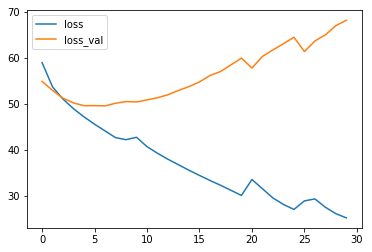

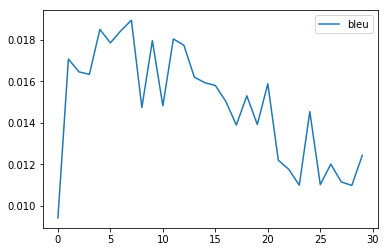

In [16]:
for key, val in history.items():
        if "loss" in key:
            plt.plot(val, label=key)
plt.legend()
plt.show()
for key, val in history.items():
    if "bleu" in key:
        plt.plot(val, label=key)
plt.legend()
plt.show()

In [54]:
i = 701
a = data["test"]["codes"][i]
print(a)
print("-"*20)
print_traverse(data["test"]["trees"][i])

Type.objects.filter(type=typeImInterestedIn)
--------------------
Module
  Expr
    Call
      Attribute
        Attribute
          Name
            Type
            Load
          objects
          Load
        filter
        Load
      keyword
        type
        Name
          typeImInterestedIn
          Load


In [22]:
len(X_trn)

21461

In [5]:
a= data["train"]["trees"][0]

In [6]:
a.children